# Определение стоимости автомобилей

В данном проекте мы будем работать с данными о подержанных автомобилях с целью разработки модели машинного обучения, которая предсказывает рыночную стоимость автомобиля на основе его характеристик. Сервис по продаже автомобилей с пробегом "Не бит, не крашен" хочет использовать эту модель для создания приложения, которое поможет привлечь новых клиентов.

Мы проанализируем данные о технических характеристиках, комплектации и ценах автомобилей, чтобы обучить и оценить различные модели машинного обучения. Важные критерии для заказчика включают:
- качество предсказания,
- время обучения модели,
- скорость предсказания.

В процессе выполнения проекта мы выполним следующие задачи:

1. Изучение и предобработка данных: обработка пропусков, аномалий и удаление неинформативных признаков.
2. Подготовка обучающей и тестовой выборок.
3. Обучение различных моделей машинного обучения, включая градиентный бустинг с использованием библиотеки LightGBM и другие алгоритмы.
4. Эксперименты с разными гиперпараметрами моделей и сравнение их характеристик: время обучения, скорость предсказания и точность результата.
5. Оценка качества моделей с использованием метрики RMSE и выбор лучшей модели на основе критериев заказчика.
6. Проверка качества выбранной модели на тестовой выборке.

По итогам проекта мы предоставим рекомендации по выбору оптимальной модели, удовлетворяющей требованиям заказчика, и предложим возможные направления для дальнейшего улучшения модели.

<div class='alert alert-success'> ✔️Хорошо, что сформулировала описание проекта, это помогает не забыть цели и особенности задачи.



</div>

## Подготовка данных

### Загрузка данных

Импортируем необходимые библиотеки и загрузим данные из CSV-файла:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')
    
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
display(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:

- Price — цена (евро)

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'RegistrationYear'}>,
        <AxesSubplot:title={'center':'Power'}>],
       [<AxesSubplot:title={'center':'Kilometer'}>,
        <AxesSubplot:title={'center':'RegistrationMonth'}>,
        <AxesSubplot:title={'center':'NumberOfPictures'}>],
       [<AxesSubplot:title={'center':'PostalCode'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

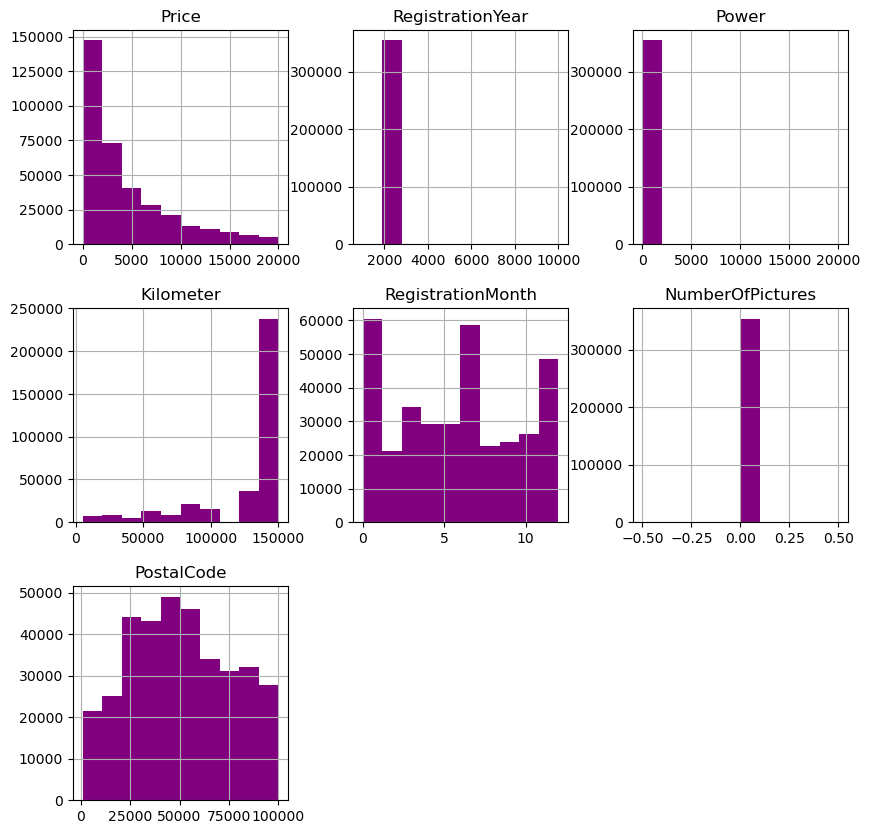

In [4]:
df.hist(color='purple', figsize=(10, 10))

Для нагладности, посмотрим на доли пропусков в столбцах в процентном соотношении.

In [5]:
missing_data = df.isnull().sum() / len(df) * 100
missing_data = missing_data[missing_data > 0]
missing_data.sort_values(ascending=False, inplace=True)
missing_data

Repaired       20.079070
VehicleType    10.579368
FuelType        9.282697
Gearbox         5.596709
Model           5.560588
dtype: float64

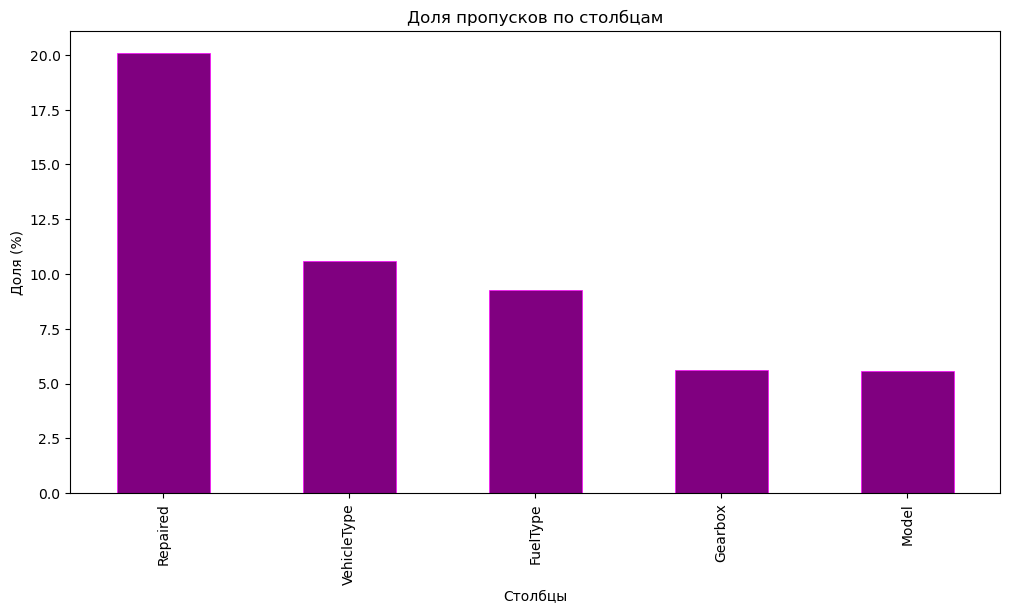

In [6]:
missing_data.plot(kind='bar', color='purple', edgecolor='magenta', linewidth=0.5, figsize=(12, 6))
plt.title("Доля пропусков по столбцам")
plt.xlabel("Столбцы")
plt.ylabel("Доля (%)")
plt.show()

После загрузки данных и вывода информации о датафрейме можно сделать следующие выводы:

1. Данные содержат 354 369 записей и 16 столбцов признаков.

2. Среди признаков есть числовые и категориальные переменные.

3. Некоторые столбцы содержат пропущенные значения, которые следует обработать:

- VehicleType: 316 879 / 354 369 (около 10.6% пропусков)
- Gearbox: 334 536 / 354 369 (около 5.6% пропусков)
- Model: 334 664 / 354 369 (около 5.5% пропусков)
- FuelType: 321 474 / 354 369 (около 9.3% пропусков)
- Repaired: 283 215 / 354 369 (около 20.1% пропусков)

4. Столбец NumberOfPictures имеет только одно уникальное значение (0), что означает, что он неинформативен и не будет полезен для обучения модели. Этот столбец следует удалить.

5. Некоторые признаки, такие как RegistrationMonth, DateCrawled, PostalCode, DateCreated и LastSeen, также являются неинформативными для обучения модели и не влияют на целевую переменную.

6. В данных могут быть аномалии, например, минимальный год регистрации автомобиля равен 1000, что является нереалистичным значением. Такие аномалии необходимо обработать.

В целом, данные требуют предварительной обработки, включая обработку пропущенных значений и аномалий. Затем данные можно разделить на обучающую и тестовую выборки для обучения и оценки моделей машинного обучения.

<div class='alert alert-success'> ✔️Отлично, первичный анализ проведен с применением диагностических инструментов Pandas,найдены особенности в данных и намечена тактика дальнейших действий. Добавил бы про наличие аномалий еще и в цене и мощности
</div>

### Обработка пропусков и аномалий

Проверим наличие дубликатов:

In [7]:
print("Количество дубликатов:", df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)

Количество дубликатов: 4


<div class='alert alert-success'> ✔️ Хорошо, явные дубликаты удалили. Обрати внимание, что практика удаления дубликатов до фильтрации неинформативных колонок (например, DateCrawled и LastSeen) оставляет неявные дубли. Хотел подчеркнуть, что, возможно, следует дубликаты определять после удаления таких колонок, чтобы и явные, и неявные найти сразу.
</div>

Для того, чтобы более точно определить верхнюю границу корректного года регистрации автомобиля, преобразуем колонку DateCrawled из формата object в формат datetime, чтобы мы могли работать с датами.

In [8]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])

Найдем самую позднюю дату с помощью функции `max()`.

In [9]:
latest_date = df['DateCrawled'].max()
print("Самая поздняя дата сбора данных:", latest_date)

Самая поздняя дата сбора данных: 2016-04-07 14:36:58


Построим графики для визуализации данных и выявления возможных закономерностей или зависимостей:
- Гистограммы распределения числовых признаков

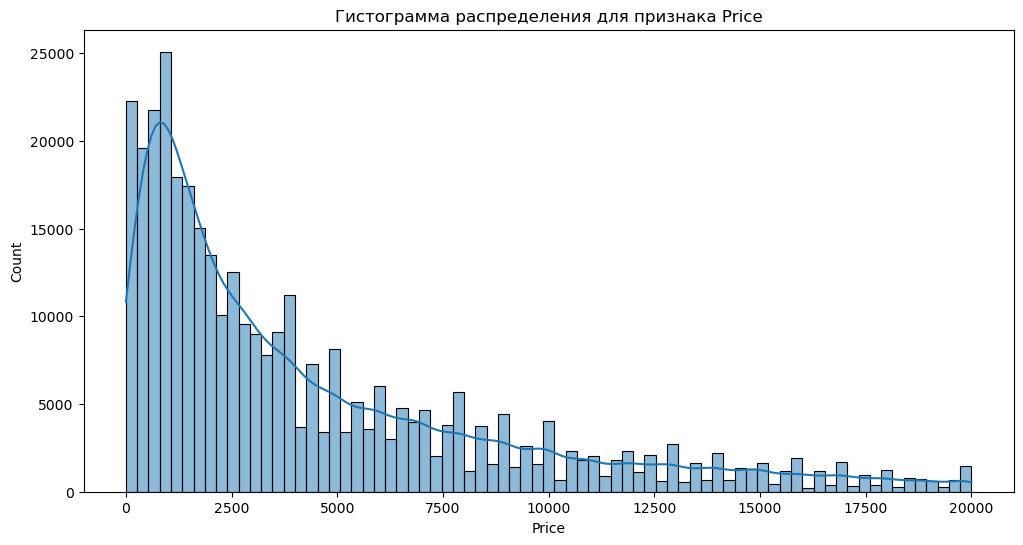

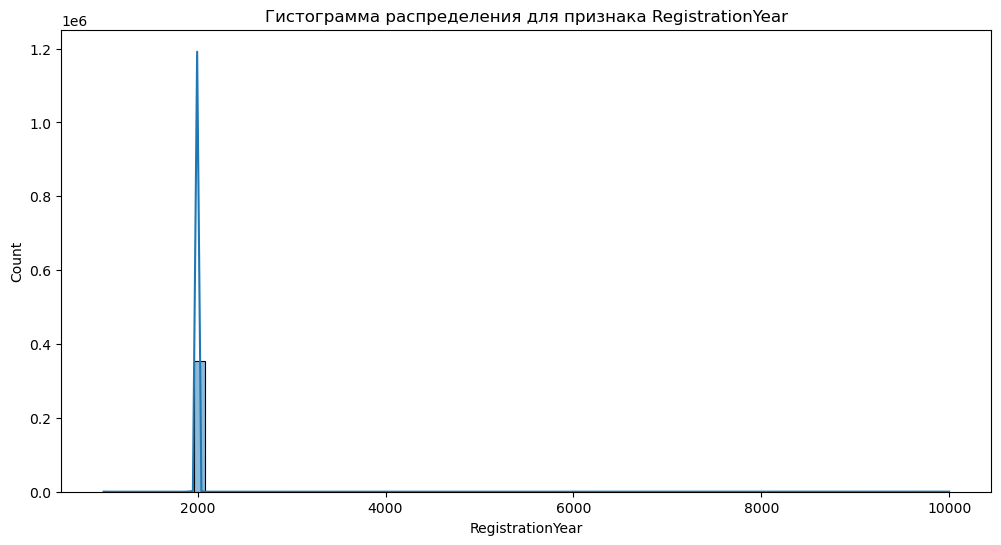

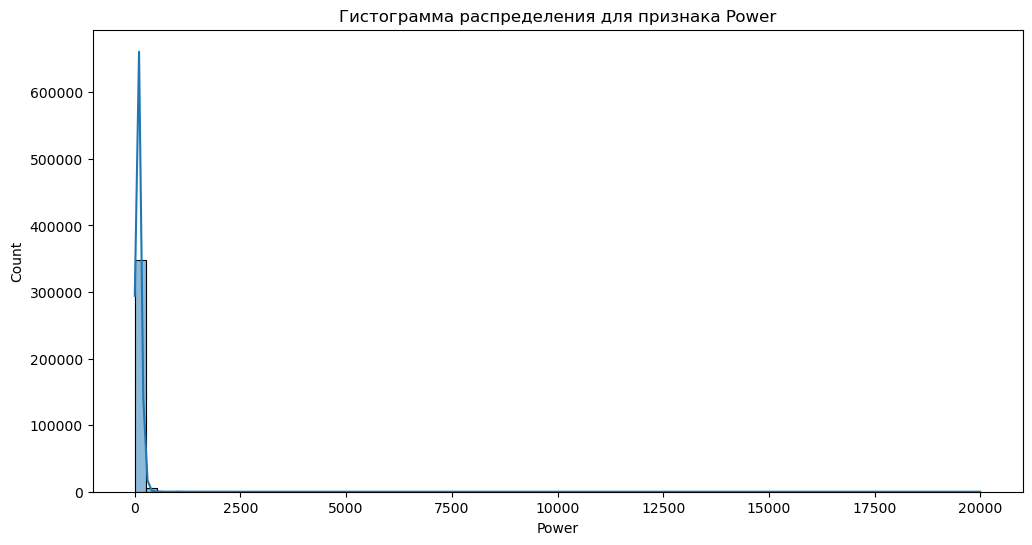

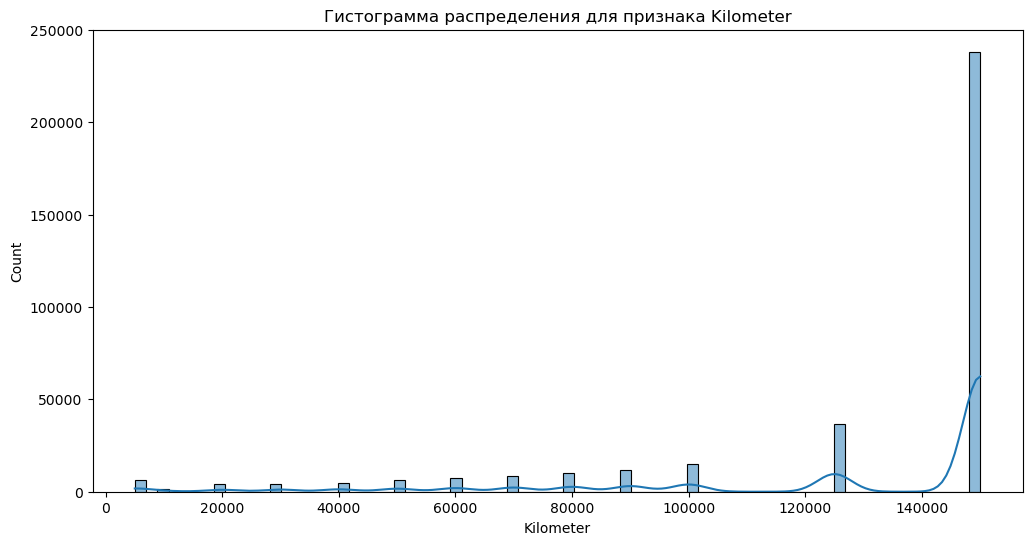

In [10]:
features = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

for feature in features:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x=feature, kde=True, bins=75)
    plt.title(f'Гистограмма распределения для признака {feature}')
    plt.show()

Очистим данные от таких нереалистичных данных, как нулевая стоимость, год регистрации автомобиля больше текущего, и мощность л/с больше 2000 (кол-во л/с у самого мощного легкового автомобиля в мире). Также неразумно использовать в исследовании данные об автомобилях, зарегистрированных ранее 1950 года, такие объекты раритетны и скорее всего не будут массово продаваться в нашем приложении. Выше мы также определили верхнюю возможную границу года регистрации автомобиля - апрель 2016 года.

In [11]:
df_copy = df

df_copy = df_copy[(df_copy['RegistrationYear'] >= 1950) &
                  ((df_copy['RegistrationYear'] < 2016) | 
                  ((df_copy['RegistrationYear'] == 2016) & (df_copy['RegistrationMonth'] <= 3)))]

<div class='alert alert-warning'>⚠️ Хорошо, явно неправильные значения из года регистраци удалили. А как считаешь по дате скачивания можно что-то сказать о верхней границе года регистрации?</div>




<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

По дате скачивания датасета можно точнее определить верхнюю границу для года регистрации. Если мы знаем, когда данные были собраны, то ни один автомобиль не мог быть зарегистрирован после этой даты.
    
Перед удалением столбца 'DateCrawled' мы нашли дату последней выгрузки - апрель 2016, поэтому используем ее как верхнюю границу.
</div>

<div class='alert alert-success'> <strong>Ревьюер(2)</strong> <br>

Точно!


</div>

Удалим признаки, которые нам не понадобятся для обучения модели.

In [12]:
columns_to_drop = ['NumberOfPictures', 'RegistrationMonth', 'DateCrawled', 'PostalCode', 'DateCreated', 'LastSeen']
df_copy = df_copy.drop(columns=columns_to_drop)
df_copy.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


<div class='alert alert-success'> ✔️ Да, эти колонки нам не пригодятся
</div>

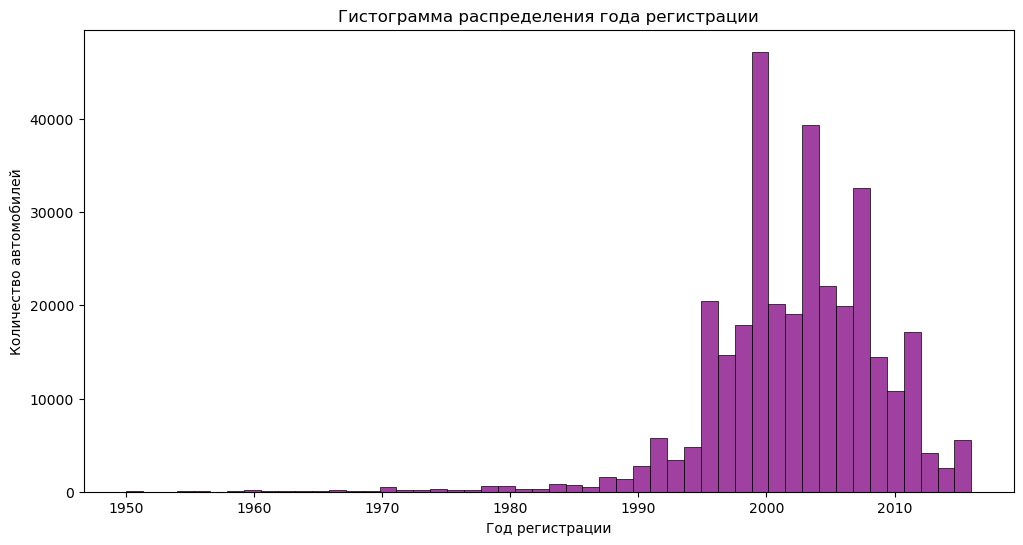

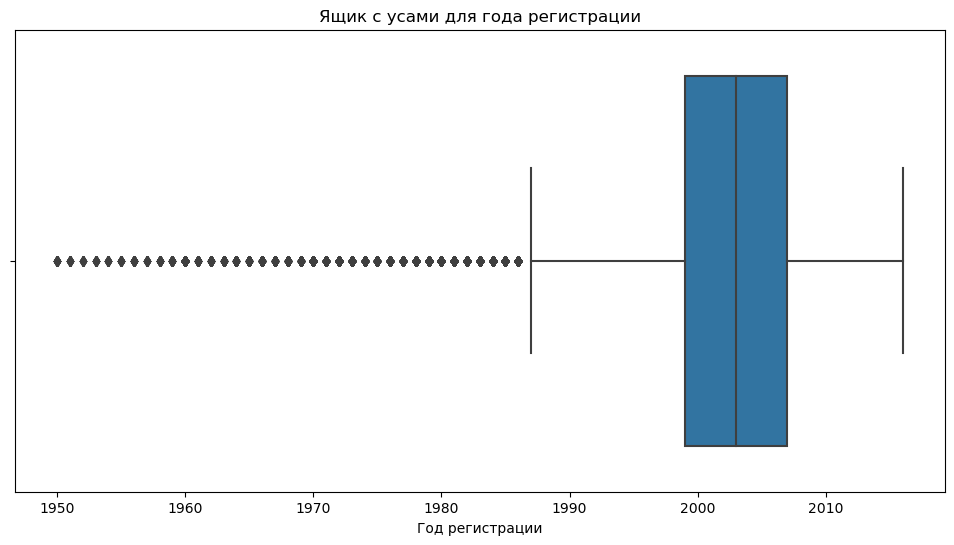

In [13]:
# Гистограмма
plt.figure(figsize=(12, 6))
sns.histplot(df_copy['RegistrationYear'], bins=50, kde=False, color='purple', edgecolor='black', linewidth=0.5)
plt.title('Гистограмма распределения года регистрации')
plt.xlabel('Год регистрации')
plt.ylabel('Количество автомобилей')
plt.show()

# Ящик с усами (boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_copy['RegistrationYear'])
plt.title('Ящик с усами для года регистрации')
plt.xlabel('Год регистрации')
plt.show()

<div class='alert alert-success'> ✔️Хорошо, что изучаешь колонки с гистограммой и диаграммой размаха, чтобы определить распределение и выбросы.


</div>

Из графиков мы видим, что большая часть оставшихся объектов была поставлена на учет в период с 2000 по 2008 год, такое же распределение мы получали в начале исследования методом describe().

Верхний интервал цены оставим прежним, но очистим данные от объектов, стоимостью меньше 100 долларов.

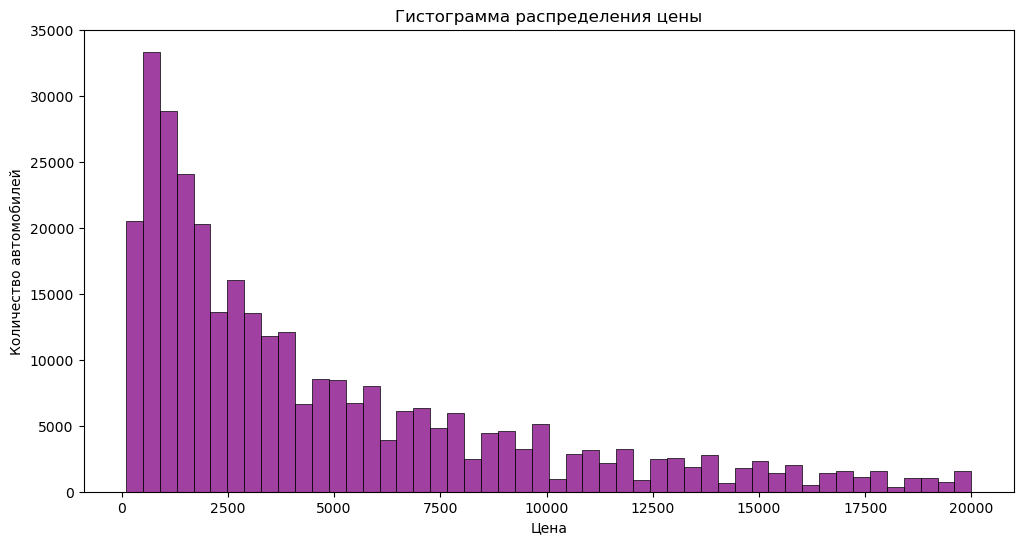

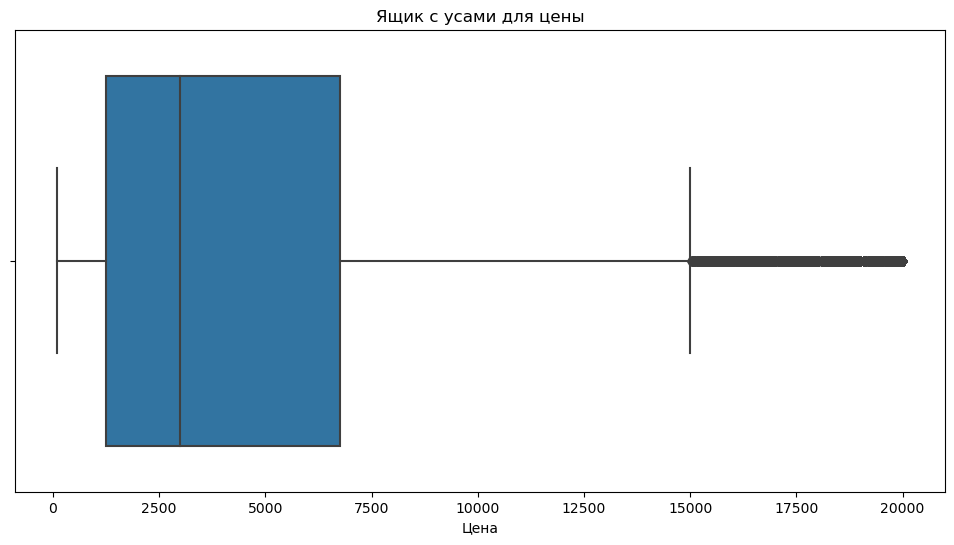

In [14]:
df_copy = df_copy[df_copy['Price'] >= 100]

# Гистограмма
plt.figure(figsize=(12, 6))
sns.histplot(df_copy['Price'], bins=50, kde=False, color='purple', edgecolor='black', linewidth=0.5)
plt.title('Гистограмма распределения цены')
plt.xlabel('Цена')
plt.ylabel('Количество автомобилей')
plt.show()

# Ящик с усами (boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_copy['Price'])
plt.title('Ящик с усами для цены')
plt.xlabel('Цена')
plt.show()

<div class='alert alert-danger'>❌ ОК, низкие цены нашла, но сделала границу слишком высокой из-за чего удалила треть данных.


</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Не сразу поняла в чем ошибка)) Исправлено
</div>

<div class='alert alert-success'> <strong>Ревьюер(2)</strong> <br>

Супер!


</div>

Из графиков мы видим, что основная часть объектов находится в пределах стоимости от 100 до 6000 долларов. Данные также поменялись незначительно в сравнении с датасетом до очистки.

Для обработки нулевых значений и сохранения данных, заполним их медианными значениями для каждого бренда. Верхняя граница мощности автомобиля будет 2000 л/с. 

In [15]:
# Словарь с медианными значениями мощности для каждого бренда
median_power_per_brand = df_copy[df_copy['Power'] != 0].groupby('Brand')['Power'].median().to_dict()

# Применим словарь к строкам с нулевой мощностью
df_copy.loc[df_copy['Power'] == 0, 'Power'] = df_copy[df_copy['Power'] == 0]['Brand'].map(median_power_per_brand)

# Проверим строки с нулевой мощностью
df_copy[df_copy['Power'] == 0].shape[0]

0

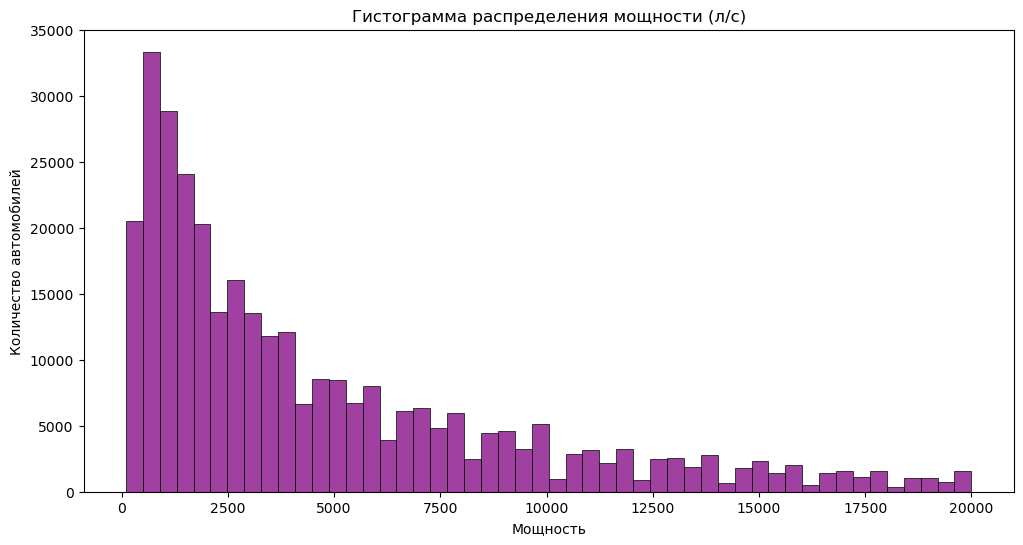

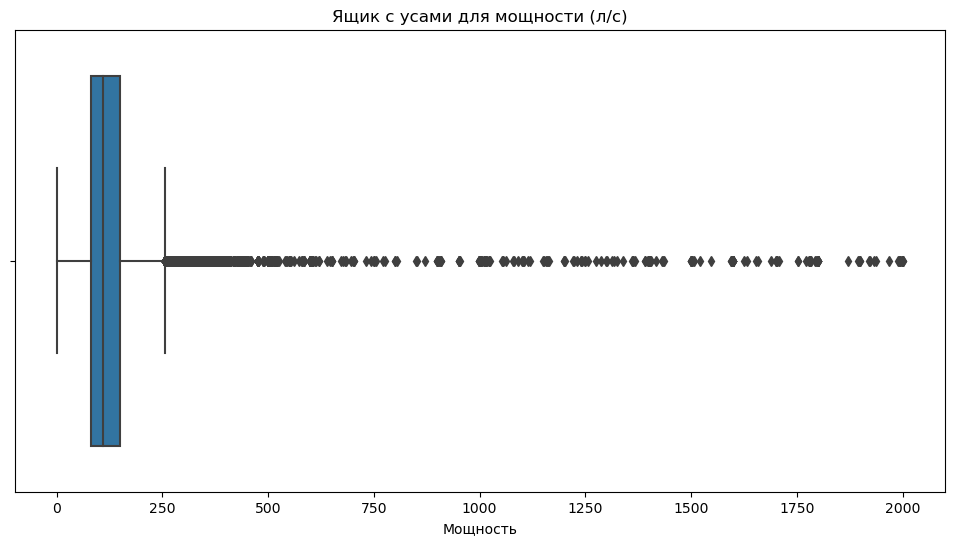

In [16]:
df_copy = df_copy[df_copy['Power'] <= 2000]

# Гистограмма
plt.figure(figsize=(12, 6))
sns.histplot(df_copy['Price'], bins=50, kde=False, color='purple', edgecolor='black', linewidth=0.5)
plt.title('Гистограмма распределения мощности (л/с)')
plt.xlabel('Мощность')
plt.ylabel('Количество автомобилей')
plt.show()

# Ящик с усами (boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_copy['Power'])
plt.title('Ящик с усами для мощности (л/с)')
plt.xlabel('Мощность')
plt.show()

Несмотря на то, что большая часть объектов находится в пределах мощности до 250 л/с, есть и много автомобилей с гораздо большим значением. Оставим их в данных, так как это могут быть спортивные элитные автомобили.

- Матрица корреляции

<div class='alert alert-warning'>⚠️ Ок, аномалии в мощности отфильтровала, правильно отметила, что авто с большой мощностью стоит оставить. Однако так как строк с нулевой мощностью достаточно много, можно было поработать с ними, как с пропусками и заполнить, например, медианой по бренду <a href = 'https://zen.yandex.ru/media/id/5ee6f73b7cadb75a66e4c7e3/zapolnenie-propuskov-kategorialnoi-modoi-6278da62f680416ea338bd9c'> по аналогии с категориальными модами </a>.
</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Для того, чтобы сохранить больше данных для анализа, нулевые значения заполнила медианой по бренду.
</div>

<div class='alert alert-success'> <strong>Ревьюер(2)</strong> <br>

ОК


</div>

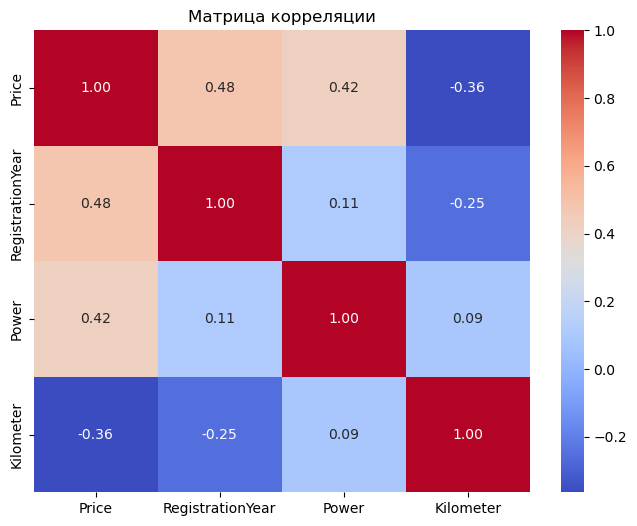

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_copy.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Матрица корреляции")
plt.show()

Исходя из матрицы корреляции, можно сделать следующие выводы:

1. Цена (Price) положительно коррелирует с годом регистрации (RegistrationYear) и мощностью (Power). Это ожидаемо, так как более новые и мощные автомобили, как правило, стоят дороже.

2. Цена (Price) отрицательно коррелирует с пробегом (Kilometer). Это тоже ожидаемо, так как автомобили с большим пробегом обычно стоят дешевле, хотя здесь корреляция не слишком сильная.

3. Между пробегом (Kilometer) и годом регистрации (RegistrationYear) также присутствует небольшая отрицательная корреляция. Это значит, что более старые автомобили имеют, как правило, больший пробег, что является логичным предположением.

В целом, матрица корреляции показывает наличие ожидаемых зависимостей между признаками, но стоит учесть, что корреляция очень слабая.

<div class='alert alert-success'> ✔️Выводы логичны и обоснованны
</div>


- Гистограммы распределения категориальных признаков

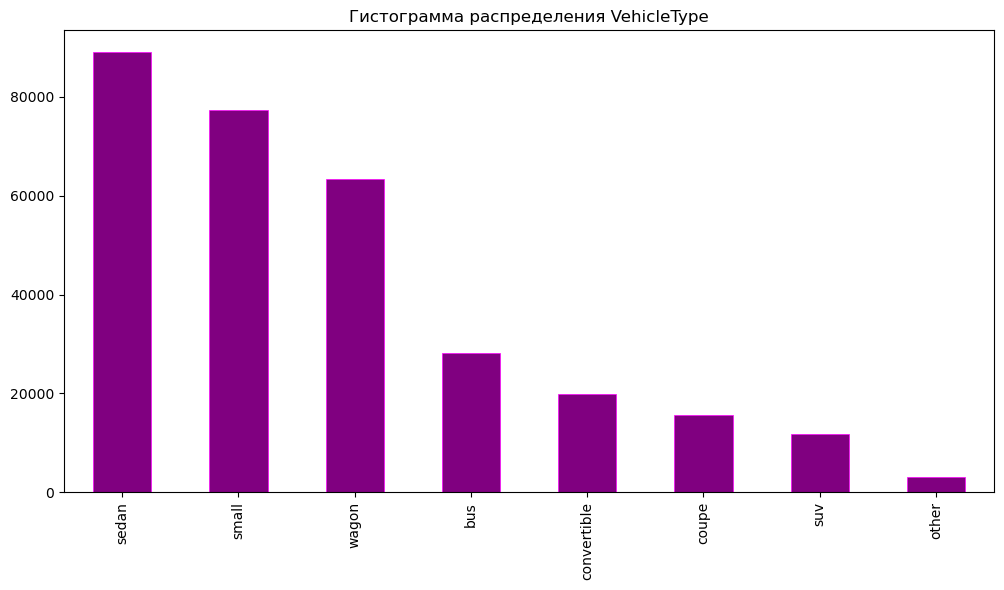

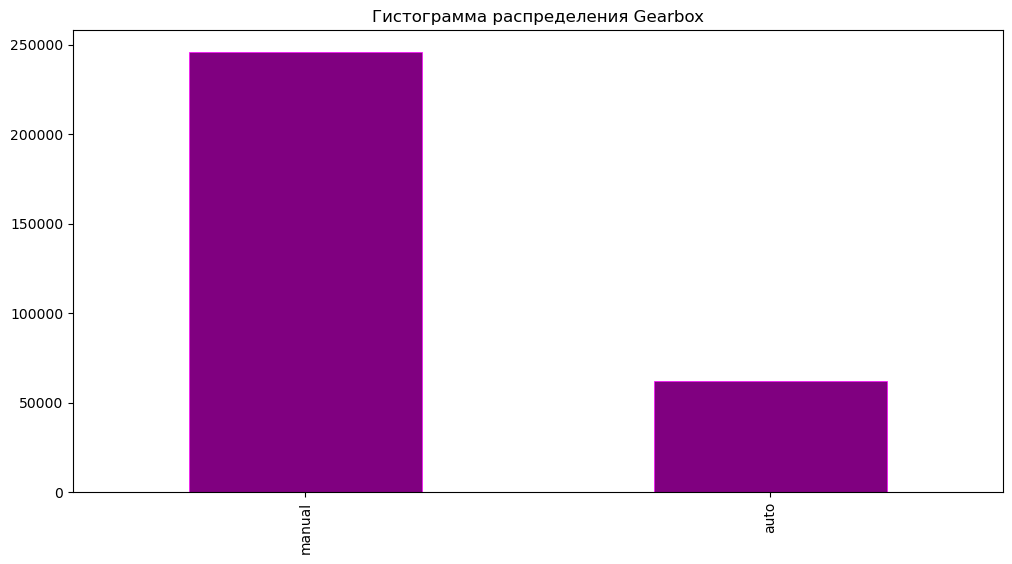

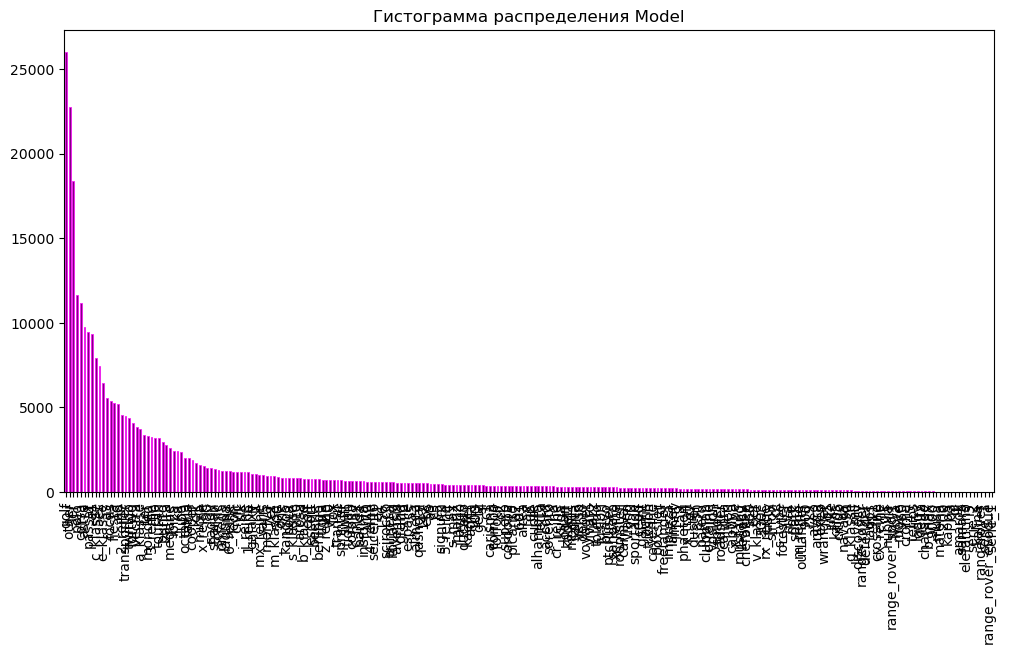

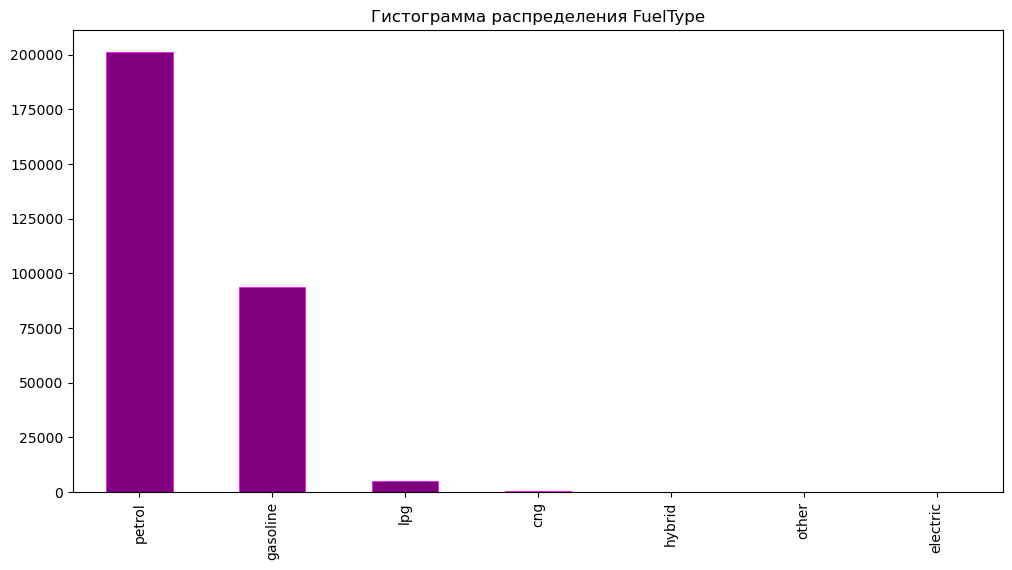

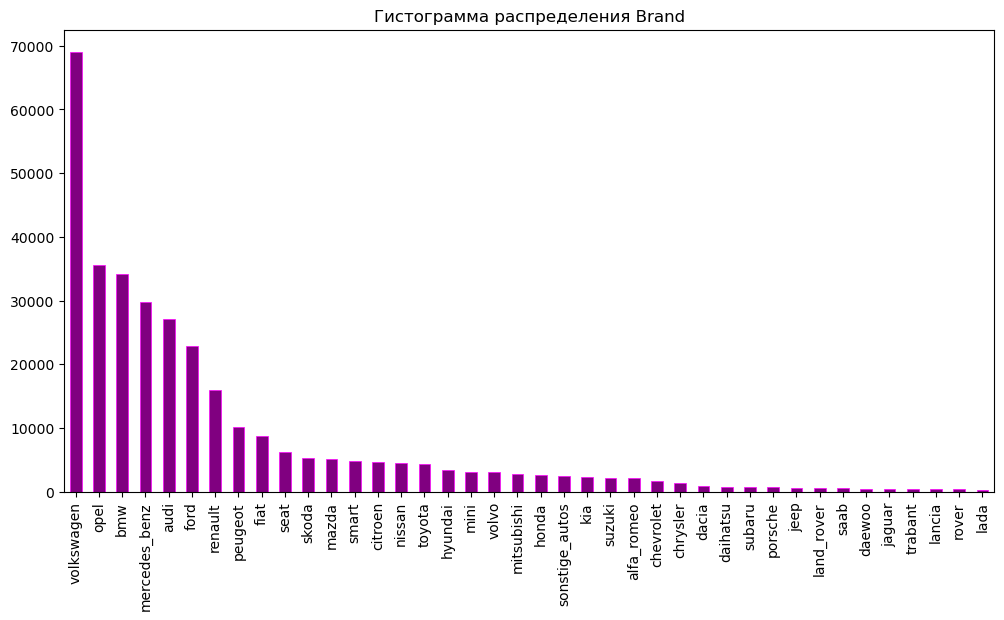

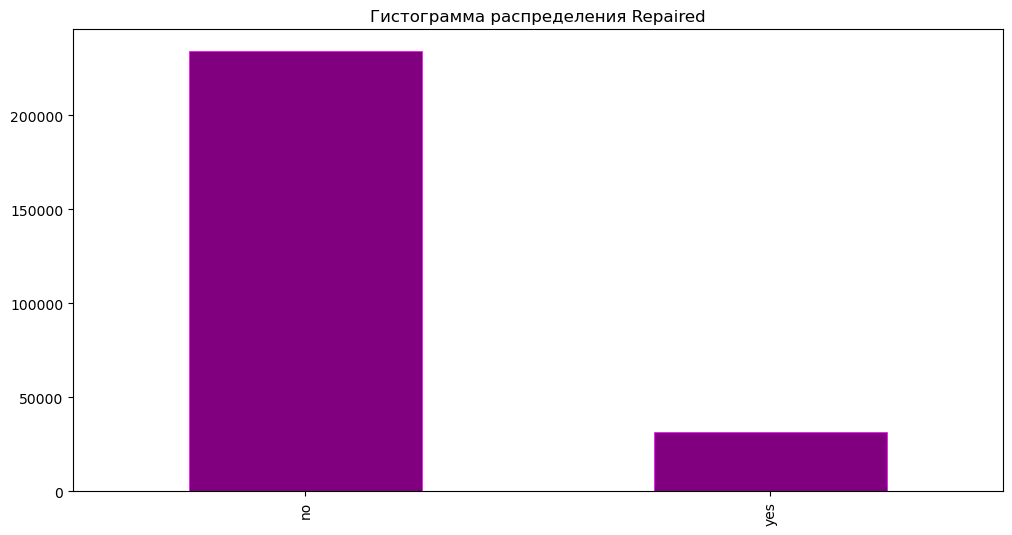

In [18]:
features_cat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

for feature in features_cat:
    plt.figure(figsize=(12,6))
    df_copy[feature].value_counts().plot.bar(color='purple', edgecolor='magenta', linewidth=0.5)
    plt.title(f'Гистограмма распределения {feature}')
    plt.show()

Для анализа взаимосвязей между категориальными признаками используем меру ассоциации Cramér's V, потому что традиционные меры корреляции, такие как корреляция Пирсона, предназначены только для количественных (числовых) переменных и не подходят для анализа взаимосвязи между категориальными переменными. Cramér's V разработан специально для измерения взаимосвязи между категориальными переменными, учитывая их особенности и тип данных.

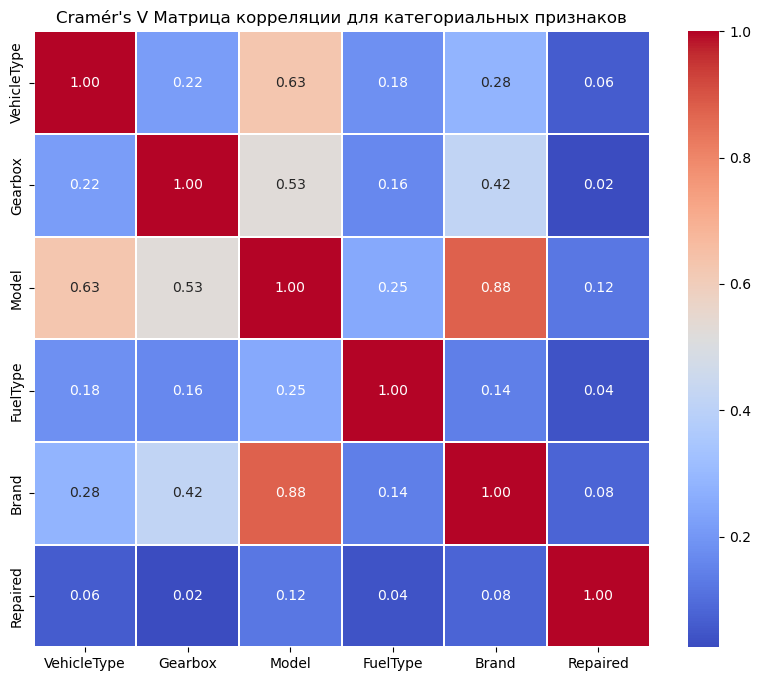

In [19]:
# функция cramers_v вычисляет корреляцию между двумя категориальными признаками
# с помощью меры ассоциации Cramér's V

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

corr_matrix = pd.DataFrame(index=features_cat, columns=features_cat)

for i in features_cat:
    for j in features_cat:
        corr_matrix.loc[i, j] = cramers_v(df_copy[i], df_copy[j])

# визуализация матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=0.1)
plt.title("Cramér's V Матрица корреляции для категориальных признаков")
plt.show()

<div class='alert alert-success'> ✔️ Отлично, взаимосвязи между категориями так же получены.
</div>


Так как зависимости между признаком Repaired, показывающим, была машина в ремонте или нет и другими признаками отсутствует, заменим пропуски в этом столбце значениями 'unknown'.

In [20]:
df_copy['Repaired'] = df_copy['Repaired'].fillna('unknown')

Между признаками Model и Brand достаточно высокая корреляция (0.88). Можно заполнить пропуски в столбце Model, используя данные из столбца Brand. Это может не дать идеальных результатов, но все же лучше, чем заполнение пропусков константным значением, таким как 'unknown', так как это позволяет сохранить некоторую информацию о связи между Model и Brand.

Определим функцию `safe_mode`, которая будет использоваться для безопасного вычисления моды. Это необходимо, потому что иногда mode() может вернуть пустой результат (например, когда все значения в группе уникальны), и в таких случаях мы вернем значение 'unknown'.

In [21]:
def safe_mode(x):
    if len(x.mode()) > 0:
        return x.mode()[0]
    else:
        return 'unknown'

df_copy['Model'].fillna(df_copy.groupby('Brand')['Model'].transform(safe_mode), inplace=True)

<div class='alert alert-success'> ✔️👍
</div>


Так как корреляция между оставшимися признаками незначительная, заполним пропуски в этих столбцах значением 'unknown'.

In [22]:
df_copy.fillna('unknown', inplace=True)

<div class='alert alert-success'> ✔️Ок, оставшиеся пропуски заполняем новой категорией. Отмечу, что в колонках типа кузова и типа топлива есть значение 'other', которое можно было объединить с новой категорией (например, заполнять значением other)
</div>

In [23]:
df_copy.isnull().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [24]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322079 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             322079 non-null  int64 
 1   VehicleType       322079 non-null  object
 2   RegistrationYear  322079 non-null  int64 
 3   Gearbox           322079 non-null  object
 4   Power             322079 non-null  int64 
 5   Model             322079 non-null  object
 6   Kilometer         322079 non-null  int64 
 7   FuelType          322079 non-null  object
 8   Brand             322079 non-null  object
 9   Repaired          322079 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


На данном этапе работы мы заполнили пропуски и очистили данные от аномалий. В ходе анализа были сделаны следующие шаги:

1. Определено количество пропусков в каждом столбце и их доли от общего числа данных.
2. Удалены столбцы с неинформативными данными, которые не влияют на целевую переменную, такие как NumberOfPictures, RegistrationMonth, DateCrawled, PostalCode, DateCreated и LastSeen.
3. Исследованы и удалены аномалии в столбце 'RegistrationYear', оставили только автомобили, зарегистрированные в промежутке между 1950 и 2023 годами.
4. Проанализировано распределение данных в столбце 'Price' и удалены аномальные значения.
5. Удалены строки с выбросами в мощности автомобиля 'Power', оставлены значения в интервале от 1-2000 л/с.
6. Рассмотрена корреляции между признаками для числовых и категориальных переменных.
7. Заполнены пропуски в столбце 'Model', при помощи информации о марке автомобиля ('Brand'). В качестве значения для заполнения пропусков мы выбрали моду.
8. Заполнены пропуски в столбцах 'Repaired', 'VehicleType', 'Gearbox ' и 'FuelType' значением 'unknown', так как не было обнаружено явной зависимости между этими признаками и другими переменными.

### Подготовка данных для обучения моделей

Во избежание утечки данных из обучающей выборки в тестовую и валидационную, сначала следует разделить данные на выборки, а затем кодировать категориальные признаки с использованием One-Hot Encoding и масштабировать числовые признаки.

Разделим данные на обучающую, валидационную и тестовую выборки в соотношении 60/20/20.

In [25]:
X = df_copy.drop(columns=['Price'])
y = df_copy['Price']

# разделение данных на обучающую и временную выборки
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# разделение временной выборки на валидационную и тестовую выборки
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

<div class='alert alert-danger'>❌Корректное разделение на 3 выборки, но не обработанного, а исходного датафрейма
</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Исправила.
</div>

<div class='alert alert-success'> <strong>Ревьюер(2)</strong> <br>

ОК

</div>

При помощи `ColumnTransformer` выполним масштабирование числовых признаков и кодирование категориальных признаков с использованием One-Hot Encoding.

In [26]:
# ранее мы определяли списки с категориальными и числовыми признаками
# удалим из числовых признаков столбец 'Price'
features.remove('Price')

# создание ColumnTransformer для обработки признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_cat)])

# Применение преобразования к обучающей, валидационной и тестовой выборкам
X_train_prepared = preprocessor.fit_transform(X_train)
X_val_prepared = preprocessor.transform(X_val)
X_test_prepared = preprocessor.transform(X_test)

<div class='alert alert-success'> ✔️Отличный способ кодирования и масштабирования, не забыла, что fit нужно делать только на train выборке.
</div>

Мы успешно подготовили выборки, теперь можно приступать к этапу обучения различных моделей.

## Обучение моделей

### Линейная регрессия

Обучим две модели линейной регрессии: Lasso и Ridge. Для оценки качества моделей применим метрику RMSE, а также оценим время, необходимое для обучения каждой модели и для получения предсказаний.

In [27]:
def train_and_evaluate(model, params, X_train, y_train, X_val, y_val):
    grid_search = GridSearchCV(model, params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

    grid_search.fit(X_train, y_train)

    print("Best parameters found: ", grid_search.best_params_)
    best_model = grid_search.best_estimator_

    # Засекаем время начала обучения для лучшей модели
    start_time = time.time()
    best_model.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"Training time for the best model: {training_time:.2f} seconds")

    # Засекаем время начала предсказания
    start_time = time.time()
    predictions = best_model.predict(X_val)
    prediction_time = time.time() - start_time
    print(f"Prediction time: {prediction_time:.2f} seconds")

    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    print(f"RMSE for the best model: {rmse:.2f}\n")
    
    return best_model

Подбирем гиперпараметр alpha, который контролирует степень регуляризации. Чем больше alpha, тем сильнее регуляризация.


<div class='alert alert-danger'>❌Отлично, что умеешь подбирать гиперпараметры с GridSearchCV, плюс используешь правильный подход к измерению времени. Но нам интересно время обучения и предсказания модели с лучшими гиперпараметрами, время подбора гиперпараметров нас не интересует. Проще всего измерить время обучения взять из <a href='https://dzen.ru/media/id/5ee6f73b7cadb75a66e4c7e3/kliuchevye-pliushki-ot-podbora-giperparametrov-v-sklearn-63464daff5b09e156159e05a'> cv_results_ </a> либо измерить, добавив строку best_model.fit... и измерение времени ее исполнения.
</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Исправлено.
</div>

<div class='alert alert-success'> <strong>Ревьюер(2)</strong> <br>

Молодец!

</div>

In [28]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

print("Training and evaluation for Lasso:")
best_model_lasso = train_and_evaluate(Lasso(random_state=42), param_grid, X_train_prepared, y_train, X_val_prepared, y_val)

print("Training and evaluation for Ridge:")
best_model_ridge = train_and_evaluate(Ridge(random_state=42), param_grid, X_train_prepared, y_train, X_val_prepared, y_val)

Training and evaluation for Lasso:


c:\Users\olean\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338088193848.6321, tolerance: 400693314.31097275
  model = cd_fast.sparse_enet_coordinate_descent(


Best parameters found:  {'alpha': 0.01}


c:\Users\olean\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338088193848.6321, tolerance: 400693314.31097275
  model = cd_fast.sparse_enet_coordinate_descent(


Training time for the best model: 157.69 seconds
Prediction time: 0.02 seconds
RMSE for the best model: 2690.76

Training and evaluation for Ridge:
Best parameters found:  {'alpha': 0.001}
Training time for the best model: 0.37 seconds
Prediction time: 0.00 seconds
RMSE for the best model: 2691.83



Обучение модели Lasso заняло значительно больше времени, чем обучение модели Ridge (158 секунд против 0,4). Однако, их производительность, судя по RMSE, очень близка. Также мы получили предупреждение о том, что модель Lasso не сошлась. Значит алгоритм обучения модели Lasso не смог найти оптимальное решение в течение заданного числа итераций. Это может быть из-за того, что число итераций было слишком мало, или из-за того, что задача слишком сложная для модели Lasso.

В целом, судя по полученным результатам, модель Ridge справилась лучше, так как она обучается быстрее и даёт схожую производительность. Но тем не менее значение метрики RMSE слишком мало, так как ожидается значение не меньше 2500.

### Дерево решений

Подберем параметры для модели DecisionTreeRegressor с использованием функции `train_and_evaluate`.

In [29]:
param_grid = {
    "max_depth": list(range(5, 20))
}

print("Training and evaluation for Decision Tree:")
best_model_tree = train_and_evaluate(DecisionTreeRegressor(random_state=42), param_grid, X_train_prepared, y_train, X_val_prepared, y_val)

Training and evaluation for Decision Tree:
Best parameters found:  {'max_depth': 16}
Training time for the best model: 11.14 seconds
Prediction time: 0.01 seconds
RMSE for the best model: 1843.52



Лучшая модель дерева решений была обучена с максимальной глубиной 16, значение RMSE равно 1843,52. Данная модель показала высокую скорость и хорошее качество предсказаний.

### Градиентный бустинг

Для обучения нашей модели градиентного бустинга мы будем использовать LightGBM. LightGBM - это библиотека, которая предлагает высокую эффективность, быструю скорость обучения и поддержку большого числа функций. Для автоматического поиска наилучших гиперпараметров для нашей модели используем GridSearchCV. Это полезный инструмент, который выполняет исчерпывающий поиск по указанной сетке гиперпараметров модели и идентифицирует комбинацию параметров, которая дает наилучший результат.

В нашем случае, мы будем настраивать два гиперпараметра: 'n_estimators' и 'learning_rate'. 'n_estimators' контролирует количество деревьев, которые мы хотим включить в наш ансамбль, а 'learning_rate' контролирует скорость, с которой наша модель учится на ошибках предыдущих деревьев.

In [30]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5]
}

# Обучаем и оцениваем модель
print("Training and evaluation for LightGBM:")
best_model_lgbm = train_and_evaluate(lgb.LGBMRegressor(random_state=42, metric = 'RMSE'), param_grid, X_train_prepared, y_train, X_val_prepared, y_val)

Training and evaluation for LightGBM:
Best parameters found:  {'learning_rate': 0.5, 'n_estimators': 150}
Training time for the best model: 0.96 seconds
Prediction time: 0.08 seconds
RMSE for the best model: 1566.52



Судя по результатам, модель градиентного бустинга LightGBM обучилась и предсказала результаты быстрее, чем другие модели. Из этого можно сделать вывод, что LightGBM действительно эффективен в плане скорости обучения и предсказания.

Более того, RMSE для модели LightGBM составил 1566.52, что является наименьшей ошибкой среди всех рассмотренных моделей. Это означает, что модель LightGBM показала лучшую точность предсказаний на валидационном наборе данных.

## Анализ моделей

Для объективного сравнения моделей, мы должны учесть следующие критерии:

1. Качество предсказания: оценивается с помощью метрики RMSE. Чем ниже RMSE, тем выше точность предсказаний модели. Значение метрики должно быть меньше 2500.

2. Время обучения: это важно для проектов, где время является критическим фактором. Если обучение модели занимает слишком много времени, это может быть препятствием для быстрого прототипирования и итераций.

3. Время предсказания: это также важный фактор, особенно в случае, если модель должна быть использована в реальном времени или в условиях большого количества запросов.

Исходя из представленных данных (время обучения, время предсказания и RMSE), модель LightGBM оказалась лучшей по всем трем критериям.

Модель LightGBM показала наименьший RMSE, что означает наивысшую точность предсказаний. Она также обучилась и предсказала результаты быстрее, чем другие модели. Это делает ее оптимальным выбором для текущего проекта.

<div class='alert alert-success'> ✔️ Хорошо, что выводы сформулированы в отдельном разделе. Рекомендовал бы оформлять результаты в более наглядном виде, например, <a href='https://dzen.ru/media/id/5ee6f73b7cadb75a66e4c7e3/otlichnyi-sposob-vizualizacii-prostyh-struktur-python-635f58ad857d443d738425a9'> в форме датафрейма</a>, чтобы произвести дополнительное впечатление на читателя.

</div>

### Проверка качества модели на тестовой выборке

In [31]:
start_time = time.time()
predicted = best_model_lgbm.predict(X_test_prepared)
print('Модель предсказывает на тестовой выборке за %.2f секунд' %(time.time() - start_time))

rmse_on_test = mean_squared_error(y_test, predicted, squared=False)
print('Итоговый RMSE на тестовой выборке:', rmse_on_test)

Модель предсказывает на тестовой выборке за 0.10 секунд
Итоговый RMSE на тестовой выборке: 1623.8414775528256


Наша лучшая модель LightGBM смогла сделать предсказания на тестовой выборке всего за 0.10 секунд. Итоговое значение RMSE (корень из среднеквадратичной ошибки) составляет примерно 1623,84. Невысокое значение RMSE говорит о хорошей работе модели.

<div class='alert alert-success'> ✔️Отлично, что есть тест, можно было здесь же добавить сравнение с dummy моделью
</div>

### Вывод

В ходе данного проекта мы выполнили ряд ключевых шагов для создания и оценки моделей машинного обучения для определения рыночной стоимости автомобиля в приложении.

Начав с обзора и подготовки наших данных, мы затем перешли к обучению нескольких моделей, включая линейную регрессию (Lasso и Ridge), дерево решений и модель градиентного бустинга, используя библиотеку LightGBM. Весь процесс обучения включал в себя оптимизацию гиперпараметров с использованием GridSearchCV, что позволило нам автоматически находить наилучшие параметры для каждой модели.

Мы провели детальное сравнение моделей, учитывая такие критерии, как качество предсказания (измеряемое с помощью RMSE), время обучения и время предсказания. Это позволило нам оценить каждую модель с разных точек зрения, учитывая требования заказчика.

В результате модель градиентного бустинга LightGBM показала лучшие результаты, достигнув наименьшего значения RMSE, при этом демонстрируя весьма конкурентоспособное время обучения и предсказания. На тестовой выборке данная модель показала RMSE около 1623,84, что является весьма хорошим показателем.

Таким образом, в ходе проекта мы успешно создали эффективную модель машинного обучения, способную решать задачу регрессии с приемлемым качеством и временем предсказания. В дальнейшем, эта модель может быть использована для предсказания на новых данных.

<div class='alert alert-info'>🏁 Отличная работа! Исследовала и предобработала признаки, рассмотрела 4 модели, сделала подбор гиперпараметров, строила красивые визуализации, хорошо структурировала проект. Осталось:
    
- исправить фильтрацию цены
- в разбиении на выборки использовать обработанный датасет
- изменить замер времени обучения
- дать обратную связь для выделенных ячеек (где требуется).




</div>

<div class='alert alert-success'> <strong>Ревьюер(2)</strong> <br>

Спасибо за сильную работу и удачной учебы, немного труда и все получится!

</div>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей